# INSTALLATIONS DATA ACQUISITION AND IMPORTS

In [ ]:
! pip install -q kaggle
! kaggle datasets download -qd swaptr/bitcoin-historical-data
! mkdir btc && unzip -q bitcoin-historical-data.zip -d btc

In [ ]:
! pip install -q neuralforecast

In [ ]:
! pip install -q cmaes
! pip install -q hpbandster ConfigSpace
! pip install -q ax-platform sqlalchemy

In [ ]:
#!pip install -q git+https://github.com/Nixtla/neuralforecast.git@feature/kan-experiment

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT, AutoLSTM, AutoNBEATS, AutoBiTCN, AutoTimesNet, AutoDeepAR
from neuralforecast.losses.pytorch import MAE

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch
import optuna

# DATA PREPROCESSING

this preprocessing needs to be equal in both training and evaluation.

In [ ]:
data = pd.read_csv('btc/data.csv')

# how much further we forecast
horizon = 5

# crop BTC data
invalid_date = '2017-01-01 00:00:00'
index = data.index[data['Date'] == invalid_date].tolist()

df = data.truncate(after=index[0])
df = df[['Date', 'Close']]
df = df.sort_values("Date", ascending=True)
df['Date'] = pd.to_datetime(df['Date'])

# scale data
scaler = StandardScaler()

# split data on train/valid and test sets (test set should be relatively small)
train_size = 0.95
split_index = int(df.shape[0] * train_size)

df['Close'] = scaler.fit_transform(df[['Close']])

split_value = len(df) - split_index
test = df.tail(split_value)
train = df.head(split_index)

# change data format for NeuralForecast
train.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
test.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

train['unique_id'] = 1
test['unique_id'] = 1

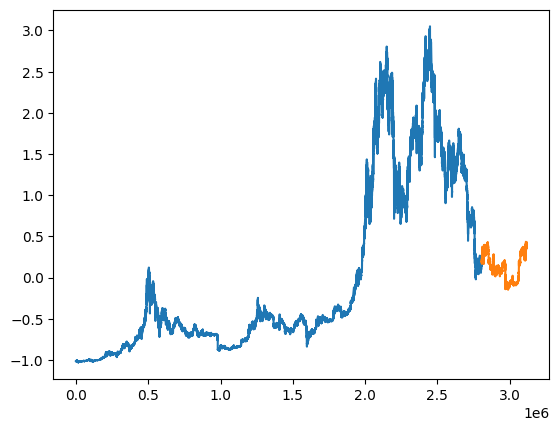

In [ ]:
# plot scaled dataset

plt.plot(range(0,len(train)), train['y'], label='Train set')
plt.plot(range(len(train), len(train)+len(test)), test['y'], label='Test set')
plt.legend()
plt.show()

# AutoModels CONFIGS

Based on source code from [here](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L1109) .

In [ ]:
# LSTM
lstm_config = {
        "input_size_multiplier": [-1, 4, 16, 32],
        "inference_input_size_multiplier": [-1],
        "h": None,
        "encoder_hidden_size": tune.choice([50, 100, 200]),
        "encoder_n_layers": tune.randint(1, 2),
        "context_size": tune.choice([5, 10, 30]),
        "decoder_hidden_size": tune.choice([64, 128, 256]),
        "learning_rate": tune.loguniform(1e-4, 1e-2),
        "max_steps": tune.choice([500, 1000, 1500]),
        "batch_size": tune.choice([8, 16]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }

# BiTCN
bitcn_config = {
        "input_size_multiplier": [1, 2, 3, 4, 5],
        "h": None,
        "hidden_size": tune.choice([16, 32]),
        "dropout": tune.uniform(0.0, 0.99),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice([None, "robust", "standard"]),
        "max_steps": tune.choice([500, 1000, 2000]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }


# TFT
tft_config = {
        "input_size_multiplier": [1, 2, 3, 4, 5],
        "h": None,
        "hidden_size": tune.choice([64, 128, 256]),
        "n_head": tune.choice([4, 8]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice([None, "robust", "standard"]),
        "max_steps": tune.choice([500, 1000, 2000]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }


# NBEATS
nbeats_config = {
        "input_size_multiplier": [1, 2, 3, 4, 5],
        "h": None,
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice([None, "robust", "standard"]),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }


def get_config(config, h):
        config_copy = config.copy()
        config_copy["input_size"] = tune.choice(
            [h * x for x in config_copy["input_size_multiplier"]]
        )
        config_copy["step_size"] = tune.choice([1, h])
        del config_copy["input_size_multiplier"]

        return config_copy


def get_lstm_config(config, h):
        config_copy = config.copy()
        config_copy["input_size"] = tune.choice(
            [h * x for x in config_copy["input_size_multiplier"]]
        )
        config_copy["inference_input_size"] = tune.choice(
            [h * x for x in config_copy["inference_input_size_multiplier"]]
        )
        del config_copy["input_size_multiplier"], config_copy["inference_input_size_multiplier"]

        return config_copy

# MODELS PREPARATION AND TRAINING

In [ ]:
lstm = AutoLSTM(
    horizon,
    loss=MAE(),
    config=get_lstm_config(lstm_config, horizon),
    search_alg=tune.search.BasicVariantGenerator(),
    num_samples=35,
    backend="ray",
)

bitcn = AutoBiTCN(
    horizon,
    loss=MAE(),
    config=None,
    search_alg=optuna.samplers.TPESampler(multivariate=True),
    num_samples=100,
    backend="optuna",
)

nbeats = AutoNBEATS(
    horizon,
    loss=MAE(),
    config=None,
    search_alg=optuna.samplers.TPESampler(multivariate=True),
    num_samples=20,
    backend="optuna",
)

tft = AutoTFT(
    horizon,
    loss=MAE(),
    config=None,
    search_alg=optuna.samplers.TPESampler(multivariate=True),
    num_samples=100,
    backend="optuna",
)


In [ ]:
# thus training with hyperparameters optimization is long we perform one model at time

models = [
    bitcn,
]

## Pandas aliases

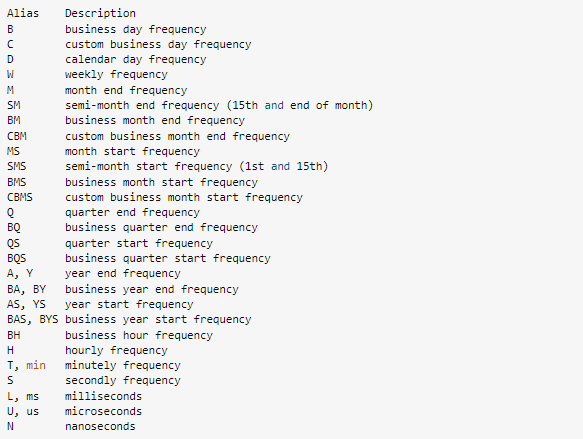

In [ ]:
# perform training

torch.cuda.empty_cache()

nf = NeuralForecast(models=models, freq='T')
nf.fit(train, val_size=2*horizon)


# PREDICTINOS AND RESOULTS VISUALIZATION

##BEST TRAINING CONFIGURATIONS (so far)

### TFT:
AFTER: 66 TRIALS

{'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.08827186143004465, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 64, 'windows_batch_size': 1024, 'random_seed': 11, 'input_size': 20, 'step_size': 5}
### BiTCN:
AFTER: 46 TRIALS

{'hidden_size': 32, 'dropout': 0.12848839287344987, 'learning_rate': 0.005652625486826798, 'scaler_type': 'standard', 'max_steps': 2000, 'batch_size': 256, 'windows_batch_size': 512, 'random_seed': 18, 'input_size': 25, 'step_size': 5}

### NBEATS:
 {'learning_rate': 0.007920715236497127, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256, 'random_seed': 1, 'input_size': 15, 'step_size': 5}

### LSTM:
AFTER: 7 TRIALS

h 5	encoder_hidden_size	50 encoder_n_layers 1	context_size 5	decoder_hidden_size	64 learning_rate 0.00019058032335399208	max_steps	1500 batch_size 16	config/loss MAE	random_seed 14	input_size 20	inference_input_size -5 valid_loss MAE

### DeepAR:
{'lstm_hidden_size': 64, 'lstm_n_layers': 1, 'lstm_dropout': 0.10130342239364357, 'learning_rate': 0.0010705850229881305, 'scaler_type': 'minmax1', 'max_steps': 2000, 'batch_size': 128, 'windows_batch_size': 128, 'random_seed': 1, 'input_size': 10, 'step_size': 5}

### TimesNet:
##

In [ ]:
# we tune LSTM model with ray backend and we obtain optimization resoluts like this

if lstm in models:
  results = nf.models[0].results.get_dataframe()
  results.to_csv('res.csv')

In [ ]:
# additionaly we can store trained models locally (colab runtime)

!mkdir /content/models

SAVED_MODELS_PATH = '/content/models'

nf.save(SAVED_MODELS_PATH)